In [1]:
import pandas as pd
from datetime import datetime

weather_data_filepath = "data/weather_data.csv"
electricity_data_filepath = "data/electricity_production_data.csv"

df_weather = pd.read_csv(weather_data_filepath, delimiter=',')
df_electricity = pd.read_csv(electricity_data_filepath, delimiter=',')

df_weather['time'] = pd.to_datetime(df_weather['referenceTime'])
df_weather['time'] = df_weather['time'].dt.tz_localize(None)
df_electricity['time'] = pd.to_datetime(df_electricity['måned'], format='%YM%m')
df_weather = df_weather.drop(columns="referenceTime")
df_electricity = df_electricity.drop(columns="måned")

df_weather['month_year'] = df_weather['time'].dt.strftime('%Y-%m')
df_electricity['month_year'] = df_electricity['time'].dt.strftime('%Y-%m')

df_merged = pd.merge(df_weather.drop(columns="time"), df_electricity.drop(columns="time"), on="month_year", suffixes=["_precipitation", "_electricity"], how="outer")
df_merged.sort_values(by='month_year', inplace=True)

def get_cropped_df(df, start_year, end_year):
    df['month_year'] = pd.to_datetime(df['month_year'], format='%Y-%m')
    cropped_df_merged = df[(df['month_year'].dt.year >= start_year) & (df['month_year'].dt.year <= end_year)]
    cropped_df_merged.reset_index(drop=True, inplace=True)
    return cropped_df_merged

df_merged_all_values = df_merged.dropna()
df_merged_all_values['month_year'] = pd.to_datetime(df_merged_all_values['month_year'])
df_merged_all_values.set_index('month_year', inplace=True)


/var/folders/d7/j_29bjyn0_lbt66yfhsy0pf00000gp/T/ipykernel_84755/176743871.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_all_values['month_year'] = pd.to_datetime(df_merged_all_values['month_year'])


In [2]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#-----------PARAMS--------------#
AR_LAG = 6
MA_LAG = 3
DIFFERENCING = 0
order=(AR_LAG,DIFFERENCING,MA_LAG)
exog=df_merged_all_values['value_precipitation']
params = {'order': order, 'exog': exog}

#################################


In [3]:
def evaluate_arima_model(X, order=order):
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [4]:
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [6]:
import warnings

p_values=range(0,3)
d_values=range(0,12)
q_values=range(0,3)
warnings.filterwarnings("ignore")
evaluate_models(df_merged_all_values['value_electricity'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=31946282181.460
ARIMA(0, 0, 1) MSE=19563069165.951
ARIMA(0, 0, 2) MSE=16658787670.745
ARIMA(0, 1, 0) MSE=18707835342.269
ARIMA(0, 1, 1) MSE=18829910881.401
ARIMA(0, 1, 2) MSE=18937379592.057
ARIMA(0, 2, 0) MSE=37092197968.128
ARIMA(0, 2, 1) MSE=18832362854.529
ARIMA(0, 2, 2) MSE=19249122370.906
ARIMA(0, 3, 0) MSE=110263844423.667
ARIMA(0, 3, 1) MSE=37302584191.487
ARIMA(0, 3, 2) MSE=19306204410.584
ARIMA(0, 4, 0) MSE=366697547759.090
ARIMA(0, 4, 1) MSE=110871244875.061
ARIMA(0, 4, 2) MSE=38316103724.634
ARIMA(0, 5, 0) MSE=1264586310690.892
ARIMA(0, 5, 1) MSE=368902084353.434
ARIMA(0, 5, 2) MSE=114866731186.214
ARIMA(0, 6, 0) MSE=4430712374324.342
ARIMA(0, 6, 1) MSE=1273669647565.567
ARIMA(0, 6, 2) MSE=385477975164.049
ARIMA(0, 7, 0) MSE=15690888685550.529
ARIMA(0, 7, 1) MSE=4468735539432.311
ARIMA(0, 7, 2) MSE=1340907966069.155
ARIMA(0, 8, 0) MSE=56033167757213.812
ARIMA(0, 8, 1) MSE=15847505116700.359
ARIMA(0, 8, 2) MSE=4731327332440.780
ARIMA(0, 9, 0) MSE=201749967

In [ ]:
p_values=[2,6,12,24]
d_values=[0,1,12,24,36]
q_values=[1,6,12,24]
warnings.filterwarnings("ignore")
evaluate_models(df_merged_all_values['value_electricity'].values, p_values, d_values, q_values)

ARIMA(2, 0, 1) MSE=14853835640.167
ARIMA(2, 0, 6) MSE=13782999582.636
ARIMA(2, 0, 12) MSE=14188444698.893
ARIMA(2, 0, 24) MSE=14108388864.710
ARIMA(2, 1, 1) MSE=16767600020.858
ARIMA(2, 1, 6) MSE=13142457697.534
ARIMA(2, 1, 12) MSE=15686260676.519
ARIMA(2, 1, 24) MSE=16249560408.337
ARIMA(2, 12, 1) MSE=169595862038255.969
ARIMA(2, 12, 6) MSE=1657315307423592689697073815970800581472066025291776.000
ARIMA(2, 12, 12) MSE=1354112133697.941
ARIMA(2, 24, 1) MSE=440088062078647140352.000
ARIMA(2, 36, 1) MSE=302182040682068740197099747065867068234489780204461183981106942482879169273925341406123036709209854880503465334800384.000
ARIMA(2, 36, 6) MSE=4033923793036901255773067913953949689096550841224897042329641826947561794669292627923208066495953620033339995979776.000
ARIMA(2, 36, 12) MSE=3223858175500461833917465095200326905584566528444239074837806478641293023208456693794552508378908033115792712138752.000
ARIMA(2, 36, 24) MSE=2241418245089231275018767439131404795044078474545959654763024933145980

In [6]:
import warnings

p_values=[1,2,6,12]
d_values=[0,1,6]
q_values=[1,6,12]
warnings.filterwarnings("ignore")
evaluate_models(df_merged_all_values['value_electricity'].values, p_values, d_values, q_values)

ARIMA(1, 0, 1) MSE=16004741368.484
ARIMA(1, 0, 6) MSE=16045790484.553
ARIMA(1, 0, 12) MSE=15088227946.699
ARIMA(1, 1, 1) MSE=18875694350.181
ARIMA(1, 1, 6) MSE=16012842985.088
ARIMA(1, 1, 12) MSE=15485426001.082
ARIMA(1, 6, 1) MSE=452855920245.034
ARIMA(1, 6, 6) MSE=44806771431820094341120.000
ARIMA(1, 6, 12) MSE=51447699128.842
ARIMA(2, 0, 1) MSE=14853835640.167
ARIMA(2, 0, 6) MSE=13782999582.636
ARIMA(2, 0, 12) MSE=14188444698.893
ARIMA(2, 1, 1) MSE=16767600020.858
ARIMA(2, 1, 6) MSE=13142457697.534
ARIMA(2, 1, 12) MSE=15686260676.519
ARIMA(2, 6, 1) MSE=269033079942.997
ARIMA(2, 6, 6) MSE=55169204275.863
ARIMA(2, 6, 12) MSE=47417197282.680
ARIMA(6, 0, 1) MSE=14834340773.632
ARIMA(6, 0, 6) MSE=14158402654.144
ARIMA(6, 0, 12) MSE=13736317245.278
ARIMA(6, 1, 1) MSE=14942900510.794
ARIMA(6, 1, 6) MSE=13304163827.262
ARIMA(6, 1, 12) MSE=13549709411.405
ARIMA(6, 6, 1) MSE=90107201739.435
ARIMA(6, 6, 12) MSE=27663084083.330
ARIMA(12, 0, 1) MSE=14233010703.273
ARIMA(12, 0, 6) MSE=13608522525

In [16]:
AR_LAG = 2
MA_LAG = 1
DIFFERENCING = 0
order=(AR_LAG,DIFFERENCING,MA_LAG)
exog=df_merged_all_values['value_precipitation']
params = {'order': order, 'exog': exog}

#################################


model = ARIMA(df_merged_all_values['value_electricity'], order=order)
model_fit = model.fit()

In [17]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      value_electricity   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2959.860
Date:                Fri, 15 Nov 2024   AIC                           5929.720
Time:                        13:15:29   BIC                           5946.867
Sample:                    01-01-1993   HQIC                          5936.639
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.274e+05   1.31e+04     47.825      0.000    6.02e+05    6.53e+05
ar.L1          1.5562      0.100     15.619      0.000       1.361       1.751
ar.L2         -0.7188      0.071    -10.124      0.0

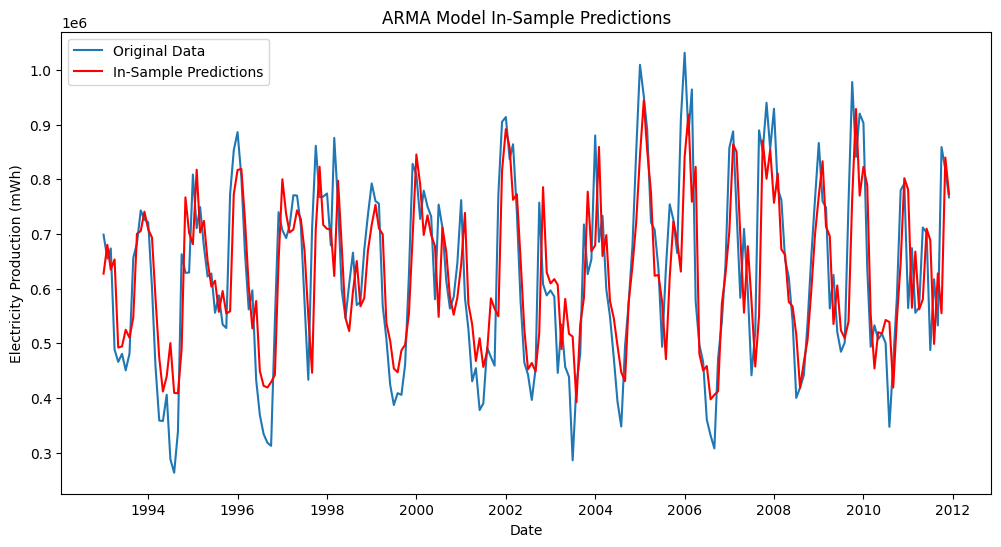

In [18]:
import matplotlib.pyplot as plt
in_sample_predictions = model_fit.predict(start=0, end=len(df_merged_all_values)-1, dynamic=False)
# Plot the original data and the in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(df_merged_all_values['value_electricity'], label='Original Data')
plt.plot(in_sample_predictions, label='In-Sample Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Production (mWh)')
plt.title('ARMA Model In-Sample Predictions')
plt.legend()
plt.show()

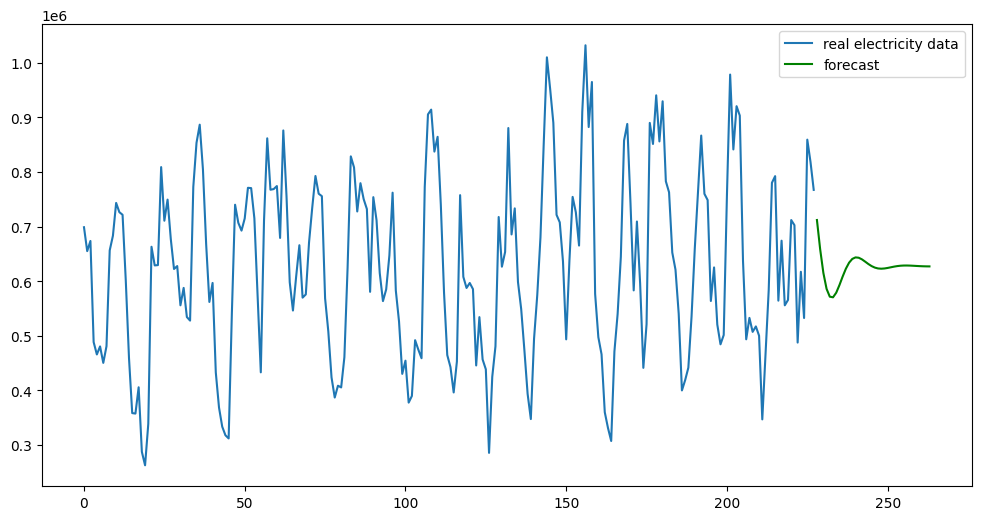

In [19]:
FORECAST_STEPS = 36
forecast = model_fit.forecast(steps=FORECAST_STEPS)
plt.figure(figsize=(12, 6))
plt.plot(range(0,len(df_merged_all_values)),df_merged_all_values['value_electricity'], label="real electricity data")
plt.plot(range(len(df_merged_all_values), len(df_merged_all_values)+FORECAST_STEPS),forecast, color='green', label="forecast")
plt.legend()
plt.show()